### Implementing ResNet50 on Fashion MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load and preprocess the Fashion MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Resize images to 32x32 and convert grayscale to 3 channels (RGB)
x_train = np.stack([x_train]*3, axis=-1)  # Convert to (28, 28, 3)
x_test = np.stack([x_test]*3, axis=-1)    # Convert to (28, 28, 3)

#### **Code Breakdown**

1. **Model Definition**:
   ```python
   model = Sequential([
   ```
   - A **Sequential model** is used, which allows for building the network layer-by-layer.

2. **Input Layer**:
   ```python
   Flatten(input_shape=(28, 28)),
   ```
   - **`Flatten` Layer**:
     - Converts the input data from a 2D shape of (28, 28) (e.g., an image) into a 1D vector.
     - Essential for feeding image data into fully connected (dense) layers.
   - **`input_shape=(28, 28)`**:
     - Specifies the input dimension of the data, which is 28x28 pixels (typical for datasets like MNIST).

3. **First Hidden Layer**:
   ```python
   Dense(128, activation='relu'),
   ```
   - **`Dense` Layer**:
     - Fully connected layer with 128 neurons.
     - Each neuron is connected to every neuron in the previous layer.
   - **Activation Function (`relu`)**:
     - The Rectified Linear Unit (ReLU) activation function introduces non-linearity, allowing the network to learn complex patterns.

4. **Second Hidden Layer**:
   ```python
   Dense(64, activation='relu'),
   ```
   - A second fully connected layer with 64 neurons.
   - Uses the **ReLU activation function** to retain non-linearity.

5. **Output Layer**:
   ```python
   Dense(10, activation='softmax')
   ```
   - **`Dense` Layer**:
     - The output layer has 10 neurons, corresponding to the 10 possible classes (e.g., digits 0-9 for MNIST).
   - **Activation Function (`softmax`)**:
     - Converts the output of the network into probabilities, where the sum of all probabilities is 1.
     - Used for multi-class classification tasks.


In [3]:
# Rescale images to 32x32 to match ResNet50 input requirements
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Initialize the ResNet50 model with ImageNet weights and no top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom top layers for Fashion MNIST
x = Flatten()(resnet_base.output)
x = Dense(512, activation='relu')(x)
x = Dense(10, activation='softmax')(x)  # 10 classes for Fashion MNIST

# Create the model
model = Model(inputs=resnet_base.input, outputs=x)

# Freeze the ResNet50 base layers for initial training
for layer in resnet_base.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

D:\Data Engineering Project\ML Project\aiwork\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


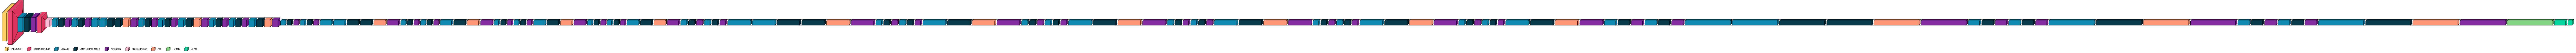

In [4]:
import visualkeras
from visualkeras import layered_view
# Visualizing model architecture
layered_view(model, legend = True)

In [9]:
# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size=128)

# Unfreeze some layers and fine-tune
for layer in resnet_base.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 118ms/step - accuracy: 0.5517 - loss: 1.2977 - val_accuracy: 0.7120 - val_loss: 0.7950
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.7184 - loss: 0.7458 - val_accuracy: 0.7517 - val_loss: 0.6864
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.7427 - loss: 0.6850 - val_accuracy: 0.7134 - val_loss: 0.7664
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 117ms/step - accuracy: 0.7540 - loss: 0.6507 - val_accuracy: 0.7549 - val_loss: 0.6528
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step - accuracy: 0.7647 - loss: 0.6287 - val_accuracy: 0.7545 - val_loss: 0.6577
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 58s 125ms/step - accuracy: 0.7664 - loss: 0.6195 - val_accuracy: 0.7692 - val_loss: 0.6335
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.7757 - loss: 0.5987 - val_accuracy: 0.7709 - val_loss: 0.6211
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 127ms/step - accuracy: 0.7746 - loss: 0

In [11]:
# Recompile and fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_tune = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 242ms/step - accuracy: 0.8204 - loss: 0.4854 - val_accuracy: 0.8056 - val_loss: 0.5455
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 233ms/step - accuracy: 0.8298 - loss: 0.4547 - val_accuracy: 0.8103 - val_loss: 0.5355
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 233ms/step - accuracy: 0.8403 - loss: 0.4276 - val_accuracy: 0.8110 - val_loss: 0.5282
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 234ms/step - accuracy: 0.8445 - loss: 0.4116 - val_accuracy: 0.8155 - val_loss: 0.5229
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 233ms/step - accuracy: 0.8511 - loss: 0.3911 - val_accuracy: 0.8199 - val_loss: 0.5135
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 236ms/step - accuracy: 0.8578 - loss: 0.3746 - val_accuracy: 0.8218 - val_loss: 0.5131
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 235ms/step - accuracy: 0.8636 - loss: 0.3581 - val_accuracy: 0.8220 - val_loss: 0.5035
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 234ms/step - accuracy: 0.8673 -

In [17]:
# Save the trained model
model.save("resnet50_fashion_mnist.h5")
print("Model saved as resnet50_fashion_mnist.h5")

Model saved as resnet50_fashion_mnist.h5


In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Load the model
loaded_model = load_model("resnet50_fashion_mnist.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate and display the classification report
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

report = classification_report(y_test_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step
Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.73      0.81      0.76      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.66      0.77      0.71      1000
       Dress       0.89      0.75      0.81      1000
        Coat       0.69      0.71      0.70      1000
      Sandal       0.89      0.94      0.92      1000
       Shirt       0.60      0.49      0.54      1000
     Sneaker       0.92      0.85      0.88      1000
         Bag       0.92      0.96      0.94      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



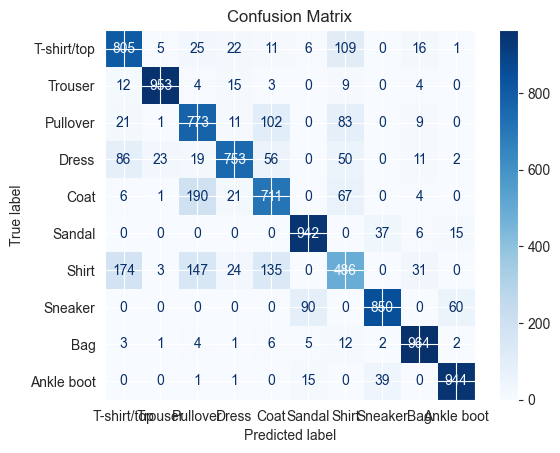

In [14]:
# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

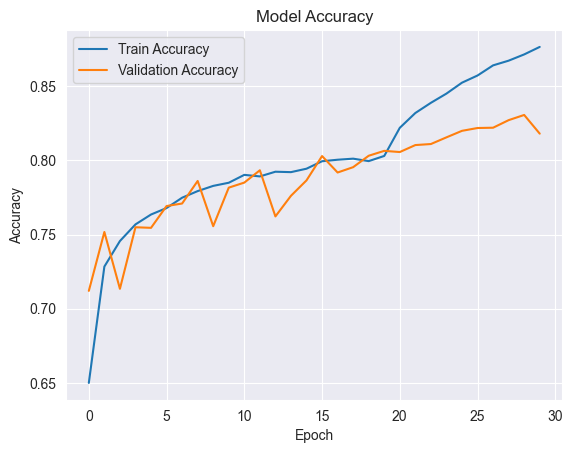

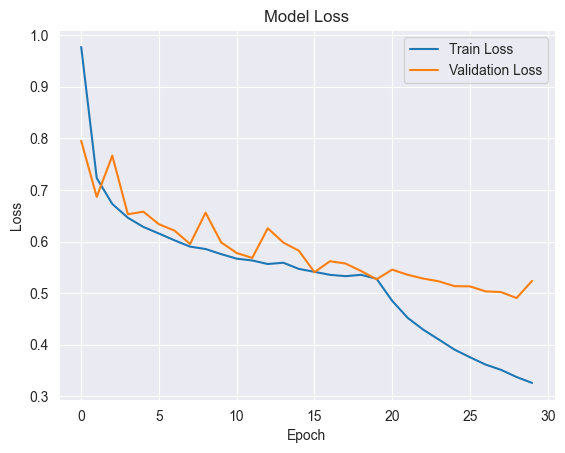

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'] + history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step


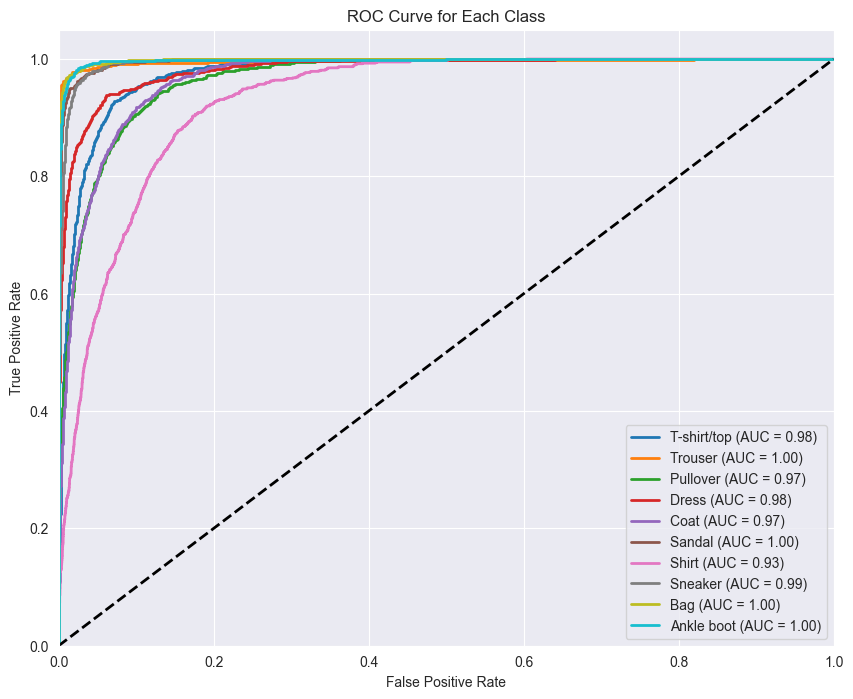

In [16]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Convert the true labels and predictions to one-hot encoding for AUC calculation
y_test_one_hot = to_categorical(y_test_classes, num_classes=10)
y_pred_proba = model.predict(x_test)  # Get predicted probabilities

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    # Compute ROC curve and AUC for each class
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
